### In this final part of the project, you should be focusing in 2 big areas:

Cluster the songs you collected:
- scale the audio features of your songs. this should create an object called scaler  (store it, you’re gonna need it in the future) and an array with scaled features, let’s call it X_scaled
- initialize a KMeans model with kmeans = KMeans(random_state=1234)(don’t waste time on parameters /number of clusters for now - use defaults!)
- fit the model to your data using kmeans.fit(X_scaled)
- create a column called cluster in your original dataframe, with the assigned cluster, using X["cluster"] = kmeans.predict(input_song)
- this process should only be done once, not every time a song is inputed! However, you are going to need the clustered dataframe X , the scaler, and the kmeans model to be loaded in your environment (i.e. notebook) when the user inputs a song.
- Tip: consider doing this through creating a module and loading it from another notebook.

-----> NOTE: This notebook continue with the notebook 'FraHilal_Spotipy_100songs_play'

### Import Lybraries

In [1266]:
import config
import spotipy
import json
import pandas as pd
from spotipy.oauth2 import SpotifyClientCredentials
import numpy as np
import pickle
from sklearn import datasets 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from matplotlib import pyplot
from sklearn.metrics import silhouette_score


sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=config.client_id, client_secret=config.client_secret))


### Link the notebook to the Spotify playlist

In [1311]:
playlist100 = sp.user_playlist_tracks("Spotify", "1qBrp7bjeGwHRSX3rjiEof",market="GB")
playlist100


{'href': 'https://api.spotify.com/v1/playlists/1qBrp7bjeGwHRSX3rjiEof/tracks?offset=0&limit=100&market=GB&additional_types=track',
 'items': [{'added_at': '2019-06-03T19:35:12Z',
   'added_by': {'external_urls': {'spotify': 'https://open.spotify.com/user/jsslhbscr09aaxfkfu91avjui'},
    'href': 'https://api.spotify.com/v1/users/jsslhbscr09aaxfkfu91avjui',
    'id': 'jsslhbscr09aaxfkfu91avjui',
    'type': 'user',
    'uri': 'spotify:user:jsslhbscr09aaxfkfu91avjui'},
   'is_local': False,
   'primary_color': None,
   'track': {'album': {'album_type': 'album',
     'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/6kBjAFKyd0he7LiA5GQ3Gz'},
       'href': 'https://api.spotify.com/v1/artists/6kBjAFKyd0he7LiA5GQ3Gz',
       'id': '6kBjAFKyd0he7LiA5GQ3Gz',
       'name': 'Aqua',
       'type': 'artist',
       'uri': 'spotify:artist:6kBjAFKyd0he7LiA5GQ3Gz'}],
     'external_urls': {'spotify': 'https://open.spotify.com/album/3hHmYc6mrl6NkmRW1ZwYvm'},
     'href': 'htt

In [1312]:
def get_playlist_tracks(username, playlist_id):
    results = sp.user_playlist_tracks(username,playlist_id,market="GB")
    tracks = results['items']
    while results['next']:
        results = sp.next(results)
        tracks.append(results['items'])
    return tracks

In [1313]:
playlist_tracks = get_playlist_tracks("Spotify", "1qBrp7bjeGwHRSX3rjiEof")
playlist_tracks

[{'added_at': '2019-06-03T19:35:12Z',
  'added_by': {'external_urls': {'spotify': 'https://open.spotify.com/user/jsslhbscr09aaxfkfu91avjui'},
   'href': 'https://api.spotify.com/v1/users/jsslhbscr09aaxfkfu91avjui',
   'id': 'jsslhbscr09aaxfkfu91avjui',
   'type': 'user',
   'uri': 'spotify:user:jsslhbscr09aaxfkfu91avjui'},
  'is_local': False,
  'primary_color': None,
  'track': {'album': {'album_type': 'album',
    'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/6kBjAFKyd0he7LiA5GQ3Gz'},
      'href': 'https://api.spotify.com/v1/artists/6kBjAFKyd0he7LiA5GQ3Gz',
      'id': '6kBjAFKyd0he7LiA5GQ3Gz',
      'name': 'Aqua',
      'type': 'artist',
      'uri': 'spotify:artist:6kBjAFKyd0he7LiA5GQ3Gz'}],
    'external_urls': {'spotify': 'https://open.spotify.com/album/3hHmYc6mrl6NkmRW1ZwYvm'},
    'href': 'https://api.spotify.com/v1/albums/3hHmYc6mrl6NkmRW1ZwYvm',
    'id': '3hHmYc6mrl6NkmRW1ZwYvm',
    'images': [{'height': 640,
      'url': 'https://i.scdn.co/im

### Organize the directories of the song deteils

In [1314]:
import pprint
pprint.pprint(playlist_tracks)

[{'added_at': '2019-06-03T19:35:12Z',
  'added_by': {'external_urls': {'spotify': 'https://open.spotify.com/user/jsslhbscr09aaxfkfu91avjui'},
               'href': 'https://api.spotify.com/v1/users/jsslhbscr09aaxfkfu91avjui',
               'id': 'jsslhbscr09aaxfkfu91avjui',
               'type': 'user',
               'uri': 'spotify:user:jsslhbscr09aaxfkfu91avjui'},
  'is_local': False,
  'primary_color': None,
  'track': {'album': {'album_type': 'album',
                      'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/6kBjAFKyd0he7LiA5GQ3Gz'},
                                   'href': 'https://api.spotify.com/v1/artists/6kBjAFKyd0he7LiA5GQ3Gz',
                                   'id': '6kBjAFKyd0he7LiA5GQ3Gz',
                                   'name': 'Aqua',
                                   'type': 'artist',
                                   'uri': 'spotify:artist:6kBjAFKyd0he7LiA5GQ3Gz'}],
                      'external_urls': {'spotify': 'h

### Create the lists for the song title, singers and id

In [1315]:

list_of_songs=[]
list_of_singers=[]
list_of_id=[]

for songs in range(0, len(playlist_tracks)):
    song_name = playlist_tracks[songs]['track']['name']
    singer_name = playlist_tracks[songs]['track']['artists'][0]['name']
    song_id = playlist_tracks[songs]['track']['id']
    list_of_songs.append(song_name)
    list_of_singers.append(singer_name)
    list_of_id.append(song_id)
    print(song_name)
    


Barbie Girl
Ayo Technology
Dragostea din tei
Tokyo Drift (Fast & Furious) - From "The Fast And The Furious: Tokyo Drift" Soundtrack
Destination Calabria - Radio Edit
I Am Your Gummy Bear (The Gummy Bear Song)
Umbrella
Boom Boom Pow
Day 'N' Nite - Crookers Remix
Hot N Cold
Just Dance
Poker Face
Single Ladies (Put a Ring on It)
Tell Me Something I Don't Know - Soundtrack
Walking On Air
Bad Romance
Bonkers
Dynamite
Imma Be
Memories (feat. Kid Cudi)
Party In The U.S.A.
Right Round
Rude Boy
Sexy Chick (feat. Akon)
Telephone
TiK ToK
California Gurls
Vem Dancar Kuduro
Firework
Fly
Lights - Single Version
Love The Way You Lie
Man Down
Moment 4 Life
Moves Like Jagger - Studio Recording From "The Voice" Performance
Only Girl (In The World)
Replay
Super Bass
Waka Waka (This Time for Africa) [The Official 2010 FIFA World Cup (TM) Song] (feat. Freshlyground)
Whip My Hair
Who's That Chick? (feat. Rihanna)
Ai Se Eu Te Pego - Ao Vivo
Black and Yellow
Give Me Everything (feat. Ne-Yo, Afrojack & Nayer)


In [1316]:
list_of_songs

['Barbie Girl',
 'Ayo Technology',
 'Dragostea din tei',
 'Tokyo Drift (Fast & Furious) - From "The Fast And The Furious: Tokyo Drift" Soundtrack',
 'Destination Calabria - Radio Edit',
 'I Am Your Gummy Bear (The Gummy Bear Song)',
 'Umbrella',
 'Boom Boom Pow',
 "Day 'N' Nite - Crookers Remix",
 'Hot N Cold',
 'Just Dance',
 'Poker Face',
 'Single Ladies (Put a Ring on It)',
 "Tell Me Something I Don't Know - Soundtrack",
 'Walking On Air',
 'Bad Romance',
 'Bonkers',
 'Dynamite',
 'Imma Be',
 'Memories (feat. Kid Cudi)',
 'Party In The U.S.A.',
 'Right Round',
 'Rude Boy',
 'Sexy Chick (feat. Akon)',
 'Telephone',
 'TiK ToK',
 'California Gurls',
 'Vem Dancar Kuduro',
 'Firework',
 'Fly',
 'Lights - Single Version',
 'Love The Way You Lie',
 'Man Down',
 'Moment 4 Life',
 'Moves Like Jagger - Studio Recording From "The Voice" Performance',
 'Only Girl (In The World)',
 'Replay',
 'Super Bass',
 'Waka Waka (This Time for Africa) [The Official 2010 FIFA World Cup (TM) Song] (feat. Fre

In [1317]:
list_of_singers

['Aqua',
 'Revelries',
 'O-Zone',
 'Teriyaki Boyz',
 'Alex Gaudino',
 'Gummibär',
 'Rihanna',
 'Black Eyed Peas',
 'Kid Cudi',
 'Katy Perry',
 'Lady Gaga',
 'Lady Gaga',
 'Beyoncé',
 'Selena Gomez',
 'Kerli',
 'Lady Gaga',
 'Dizzee Rascal',
 'Taio Cruz',
 'Black Eyed Peas',
 'David Guetta',
 'Miley Cyrus',
 'Flo Rida',
 'Rihanna',
 'David Guetta',
 'Lady Gaga',
 'Kesha',
 'Katy Perry',
 'Lucenzo',
 'Katy Perry',
 'Nicki Minaj',
 'Ellie Goulding',
 'Eminem',
 'Rihanna',
 'Nicki Minaj',
 'Maroon 5',
 'Rihanna',
 'Iyaz',
 'Nicki Minaj',
 'Shakira',
 'WILLOW',
 'David Guetta',
 'Michel Teló',
 'Wiz Khalifa',
 'Pitbull',
 'Taio Cruz',
 'Pitbull',
 'DEV',
 'Sak Noel',
 'Alexandra Stan',
 'Jennifer Lopez',
 'Beyoncé',
 'LMFAO',
 'Pitbull',
 'Nicole Scherzinger',
 'LMFAO',
 'Nayer',
 'INNA',
 'David Guetta',
 'Rihanna',
 'One Direction',
 'Rihanna',
 'Taylor Swift',
 'Die Antwoord',
 'Skrillex',
 'Ellie Goulding',
 'Carly Rae Jepsen',
 'Anna Kendrick',
 'Kesha',
 'Rihanna',
 'PSY',
 'Icona Pop

In [1318]:
list_of_id

['5ZrDlcxIDZyjOzHdYW1ydr',
 '3rdxkiSVNtrYwleW3TJMFs',
 '52Zr0sinhWTCRrQhRRY4EP',
 '0upFohXrGxIIAjyaJmCkMU',
 '5TmFTHZp7HjBXjjsFvCY6h',
 '6nFYXpBgrNcZjbtNEuc6yR',
 '49FYlytm3dAAraYgpoJZux',
 '3oDFtOhcN08qeDPAK6MEQG',
 '34sGnIHB3ZthMvHpNX1i7e',
 '0iGckQFyv6svOfAbAY9aWJ',
 '1dzQoRqT5ucxXVaAhTcT0J',
 '1QV6tiMFM6fSOKOGLMHYYg',
 '557un1HgwYMuqfWGSTmnxw',
 '1UXBbmjIrxjckrbv5EfSVT',
 '42bTIo0JrZEY9LcY3ZhUCO',
 '0SiywuOBRcynK0uKGWdCnn',
 '6ddQ5KCkvCggk3j6KdA0zL',
 '2CEgGE6aESpnmtfiZwYlbV',
 '16sbugRbf9xEKlekuQ7Whm',
 '5xYC48nOppVemY6U5GRGTb',
 '3E7dfMvvCLUddWissuqMwr',
 '3GpbwCm3YxiWDvy29Uo3vP',
 '60jzFy6Nn4M0iD1d94oteF',
 '7zc3J2gTnGj9AQrO9xxPqP',
 '6nCDnzErqalOaIY3EJM8NK',
 '0HPD5WQqrq7wPWR7P7Dw1i',
 '6tS3XVuOyu10897O3ae7bi',
 '6ku3i5WNrsY3qhOq6ua9TL',
 '4lCv7b86sLynZbXhfScfm2',
 '2E1RGgFtr1X4H6glXOtABo',
 '5aTsxlQlq0vIedDWZoqMWN',
 '15JINEqzVMv3SvJTAXAKED',
 '1Bx0zEdVjkFlV27iKaePug',
 '1ia019RqDK2o4QiANR1Dyn',
 '7pYfyrMNPn3wtoCyqcTVoI',
 '0AH6WMe3OlAlUb5miXt2FQ',
 '4E5P1XyAFtrjpiIxkydly4',
 

### Create DataFrames for all the lists

In [1319]:
list_of_id = pd.DataFrame(list_of_id)
list_of_id.columns = ['id']
list_of_id

,id
0,5ZrDlcxIDZyjOzHdYW1ydr
1,3rdxkiSVNtrYwleW3TJMFs
2,52Zr0sinhWTCRrQhRRY4EP
3,0upFohXrGxIIAjyaJmCkMU
4,5TmFTHZp7HjBXjjsFvCY6h
...,...
95,3W3KtDwAIg3mAruSpnfG3Q
96,4XPWKmy05Rcff6TLHNoNF8
97,7vS3Y0IKjde7Xg85LWIEdP
98,3DmW6y7wTEYHJZlLo1r6XJ


In [1320]:
list_of_songs = pd.DataFrame(list_of_songs)
list_of_songs.columns = ['Song']
list_of_songs

,Song
0,Barbie Girl
1,Ayo Technology
2,Dragostea din tei
3,"Tokyo Drift (Fast & Furious) - From ""The Fast ..."
4,Destination Calabria - Radio Edit
...,...
95,Fancy
96,Ghost
97,Problem
98,Shower


In [1321]:
list_of_singers = pd.DataFrame(list_of_singers)
list_of_singers.columns = ['Singer']
list_of_singers

,Singer
0,Aqua
1,Revelries
2,O-Zone
3,Teriyaki Boyz
4,Alex Gaudino
...,...
95,Iggy Azalea
96,Ella Henderson
97,Ariana Grande
98,Becky G


In [1322]:
list_of_id

,id
0,5ZrDlcxIDZyjOzHdYW1ydr
1,3rdxkiSVNtrYwleW3TJMFs
2,52Zr0sinhWTCRrQhRRY4EP
3,0upFohXrGxIIAjyaJmCkMU
4,5TmFTHZp7HjBXjjsFvCY6h
...,...
95,3W3KtDwAIg3mAruSpnfG3Q
96,4XPWKmy05Rcff6TLHNoNF8
97,7vS3Y0IKjde7Xg85LWIEdP
98,3DmW6y7wTEYHJZlLo1r6XJ


### Merge song, singer and id in one data frame

In [1323]:
list_of_singers['list_of_songs'] = list_of_songs
list_of_singers['list_of_id'] = list_of_id
Songs_df = list_of_singers
Songs_df

,Singer,list_of_songs,list_of_id
0,Aqua,Barbie Girl,5ZrDlcxIDZyjOzHdYW1ydr
1,Revelries,Ayo Technology,3rdxkiSVNtrYwleW3TJMFs
2,O-Zone,Dragostea din tei,52Zr0sinhWTCRrQhRRY4EP
3,Teriyaki Boyz,"Tokyo Drift (Fast & Furious) - From ""The Fast ...",0upFohXrGxIIAjyaJmCkMU
4,Alex Gaudino,Destination Calabria - Radio Edit,5TmFTHZp7HjBXjjsFvCY6h
...,...,...,...
95,Iggy Azalea,Fancy,3W3KtDwAIg3mAruSpnfG3Q
96,Ella Henderson,Ghost,4XPWKmy05Rcff6TLHNoNF8
97,Ariana Grande,Problem,7vS3Y0IKjde7Xg85LWIEdP
98,Becky G,Shower,3DmW6y7wTEYHJZlLo1r6XJ


In [1324]:
song_features=[]
for song in range(0,len(playlist_tracks)):
    song_features.append(sp.audio_features(playlist_tracks[song]['track']['id'])[0])
song_features = pd.DataFrame(song_features)
song_features

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.812,0.879,1,-10.998,0,0.0397,0.0167,0.224000,0.3660,0.962,129.991,audio_features,5ZrDlcxIDZyjOzHdYW1ydr,spotify:track:5ZrDlcxIDZyjOzHdYW1ydr,https://api.spotify.com/v1/tracks/5ZrDlcxIDZyj...,https://api.spotify.com/v1/audio-analysis/5ZrD...,197960,4
1,0.740,0.820,9,-6.695,0,0.1300,0.0183,0.000005,0.3130,0.354,126.042,audio_features,3rdxkiSVNtrYwleW3TJMFs,spotify:track:3rdxkiSVNtrYwleW3TJMFs,https://api.spotify.com/v1/tracks/3rdxkiSVNtrY...,https://api.spotify.com/v1/audio-analysis/3rdx...,165739,4
2,0.802,0.966,0,-3.933,1,0.0424,0.1800,0.000000,0.0611,0.684,130.099,audio_features,52Zr0sinhWTCRrQhRRY4EP,spotify:track:52Zr0sinhWTCRrQhRRY4EP,https://api.spotify.com/v1/tracks/52Zr0sinhWTC...,https://api.spotify.com/v1/audio-analysis/52Zr...,215387,4
3,0.757,0.892,6,-5.321,1,0.1240,0.1780,0.000042,0.0719,0.936,127.014,audio_features,0upFohXrGxIIAjyaJmCkMU,spotify:track:0upFohXrGxIIAjyaJmCkMU,https://api.spotify.com/v1/tracks/0upFohXrGxII...,https://api.spotify.com/v1/audio-analysis/0upF...,255947,4
4,0.627,0.954,2,-4.804,1,0.0425,0.0015,0.000814,0.2920,0.312,128.016,audio_features,5TmFTHZp7HjBXjjsFvCY6h,spotify:track:5TmFTHZp7HjBXjjsFvCY6h,https://api.spotify.com/v1/tracks/5TmFTHZp7HjB...,https://api.spotify.com/v1/audio-analysis/5TmF...,223112,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.912,0.716,10,-4.141,0,0.0697,0.0904,0.000000,0.0491,0.377,94.981,audio_features,3W3KtDwAIg3mAruSpnfG3Q,spotify:track:3W3KtDwAIg3mAruSpnfG3Q,https://api.spotify.com/v1/tracks/3W3KtDwAIg3m...,https://api.spotify.com/v1/audio-analysis/3W3K...,199938,4
96,0.680,0.840,9,-3.823,1,0.0414,0.0457,0.000009,0.1430,0.468,104.975,audio_features,4XPWKmy05Rcff6TLHNoNF8,spotify:track:4XPWKmy05Rcff6TLHNoNF8,https://api.spotify.com/v1/tracks/4XPWKmy05Rcf...,https://api.spotify.com/v1/audio-analysis/4XPW...,213213,4
97,0.660,0.805,1,-5.352,0,0.1530,0.0192,0.000009,0.1590,0.625,103.008,audio_features,7vS3Y0IKjde7Xg85LWIEdP,spotify:track:7vS3Y0IKjde7Xg85LWIEdP,https://api.spotify.com/v1/tracks/7vS3Y0IKjde7...,https://api.spotify.com/v1/audio-analysis/7vS3...,193920,4
98,0.699,0.529,2,-7.548,1,0.0487,0.0317,0.000036,0.2850,0.121,119.987,audio_features,3DmW6y7wTEYHJZlLo1r6XJ,spotify:track:3DmW6y7wTEYHJZlLo1r6XJ,https://api.spotify.com/v1/tracks/3DmW6y7wTEYH...,https://api.spotify.com/v1/audio-analysis/3DmW...,206167,4


#### Dropping Columns

In [1325]:
songs_details = pd.concat([list_of_songs, list_of_singers, list_of_id, song_features], axis=1)
songs_details.drop(['Song','Singer','list_of_songs','list_of_id', 'mode','key','type','id','uri','track_href','analysis_url','duration_ms','time_signature'], axis = 1, inplace = True) 
select_features = songs_details

select_features

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.812,0.879,-10.998,0.0397,0.0167,0.224000,0.3660,0.962,129.991
1,0.740,0.820,-6.695,0.1300,0.0183,0.000005,0.3130,0.354,126.042
2,0.802,0.966,-3.933,0.0424,0.1800,0.000000,0.0611,0.684,130.099
3,0.757,0.892,-5.321,0.1240,0.1780,0.000042,0.0719,0.936,127.014
4,0.627,0.954,-4.804,0.0425,0.0015,0.000814,0.2920,0.312,128.016
...,...,...,...,...,...,...,...,...,...
95,0.912,0.716,-4.141,0.0697,0.0904,0.000000,0.0491,0.377,94.981
96,0.680,0.840,-3.823,0.0414,0.0457,0.000009,0.1430,0.468,104.975
97,0.660,0.805,-5.352,0.1530,0.0192,0.000009,0.1590,0.625,103.008
98,0.699,0.529,-7.548,0.0487,0.0317,0.000036,0.2850,0.121,119.987


In [1326]:
select_features.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      100 non-null    float64
 1   energy            100 non-null    float64
 2   loudness          100 non-null    float64
 3   speechiness       100 non-null    float64
 4   acousticness      100 non-null    float64
 5   instrumentalness  100 non-null    float64
 6   liveness          100 non-null    float64
 7   valence           100 non-null    float64
 8   tempo             100 non-null    float64
dtypes: float64(9)
memory usage: 7.2 KB


### Scaling Audio Features

In [1327]:
select_features.describe()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.694820,0.78895,-4.921180,0.105361,0.064021,0.013015,0.189605,0.607879,121.723820
std,0.114592,0.13153,1.686392,0.085702,0.086530,0.072001,0.156131,0.203705,22.258253
min,0.327000,0.42800,-10.998000,0.028200,0.000079,0.000000,0.033800,0.078900,63.842000
25%,0.626250,0.71825,-5.897750,0.045925,0.007980,0.000000,0.083375,0.452250,110.023250
50%,0.712500,0.80550,-4.611500,0.070250,0.029400,0.000000,0.143000,0.630500,126.085500
75%,0.761500,0.89200,-3.868000,0.131000,0.092575,0.000206,0.260500,0.753000,129.926750
max,0.928000,0.98000,-2.117000,0.365000,0.417000,0.640000,0.979000,0.989000,193.438000


In [1328]:
scaler = StandardScaler()
scaler.fit(select_features)
X_scaled = scaler.transform(select_features)
X_scaled_df = pd.DataFrame(X_scaled, columns = select_features.columns)
display(select_features.head())
print()
display(X_scaled_df.head())

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.812,0.879,-10.998,0.0397,0.0167,0.224000,0.3660,0.962,129.991
1,0.740,0.820,-6.695,0.1300,0.0183,0.000005,0.3130,0.354,126.042
2,0.802,0.966,-3.933,0.0424,0.1800,0.000000,0.0611,0.684,130.099
3,0.757,0.892,-5.321,0.1240,0.1780,0.000042,0.0719,0.936,127.014
4,0.627,0.954,-4.804,0.0425,0.0015,0.000814,0.2920,0.312,128.016


,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,1.027735,0.688086,-3.621598,-0.770015,-0.549631,2.945056,1.135483,1.747159,0.373292
1,0.396254,0.237258,-1.057142,0.288945,-0.531047,-0.181603,0.794314,-1.252586,0.194981
2,0.940030,1.352866,0.588925,-0.738351,1.347073,-0.181673,-0.827207,0.375565,0.378169
3,0.545354,0.787421,-0.238280,0.218582,1.323843,-0.181088,-0.757686,1.618880,0.238870
4,-0.594820,1.261173,0.069836,-0.737179,-0.726177,-0.170311,0.659133,-1.459805,0.284114


In [1329]:
# save the scaler file (which contains the scaled audio features) with pickle.

import pickle

with open("scaler.pickle", "wb") as f:
    pickle.dump(scaler, f)

### Choosing K with Elbow:

##### K is the number of the clusters

Training a K-Means model with 2 clusters! 

Training a K-Means model with 3 clusters! 

Training a K-Means model with 4 clusters! 

Training a K-Means model with 5 clusters! 

Training a K-Means model with 6 clusters! 

Training a K-Means model with 7 clusters! 

Training a K-Means model with 8 clusters! 

Training a K-Means model with 9 clusters! 

Training a K-Means model with 10 clusters! 

Training a K-Means model with 11 clusters! 

Training a K-Means model with 12 clusters! 

Training a K-Means model with 13 clusters! 

Training a K-Means model with 14 clusters! 



Text(0.5, 1.0, 'Elbow Method showing the optimal k')

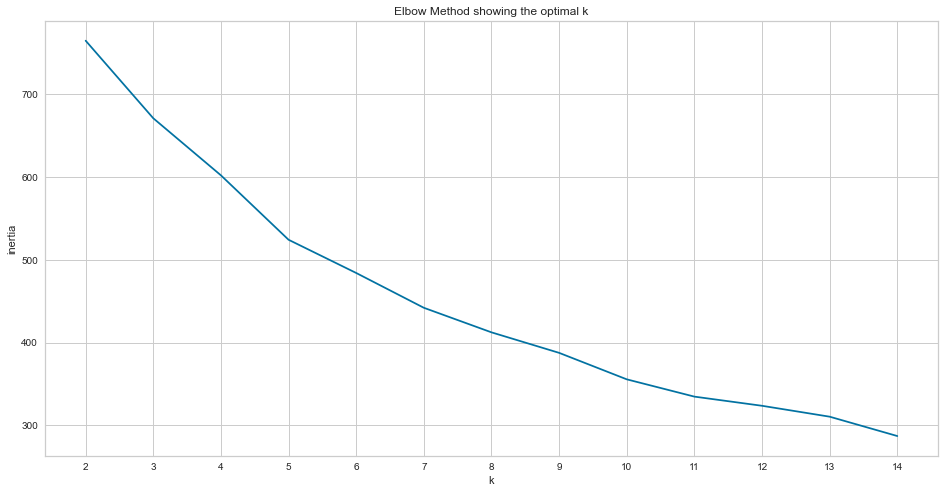

In [1330]:
K = range(2, 15)
inertia = []

for k in K:
    print("Training a K-Means model with {} clusters! ".format(k))
    print()
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(X_scaled_df)
    inertia.append(kmeans.inertia_)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

In [1331]:
# NOTE: The best key is after the most dropping line. In this case 3 or 4.

### Choosing K with Silhouette:

Text(0.5, 1.0, 'Silhouette Method showing the optimal k')

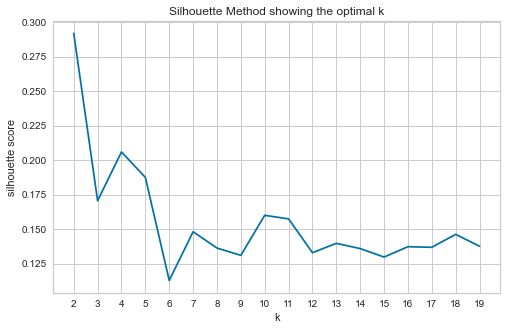

In [1332]:
K = range(2, 20)
silhouette = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(X_scaled_df)
    
    silhouette.append(silhouette_score(X_scaled_df, kmeans.predict(X_scaled_df)))


plt.figure(figsize=(8,5))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Silhouette Method showing the optimal k')

In [1333]:
# NOTE: The best key is after the longest line. In this case 3.

### Clustering the wines with K-Means

In [1334]:
kmeans = KMeans(n_clusters=3, random_state=1234)
kmeans.fit(X_scaled_df)

KMeans(n_clusters=3, random_state=1234)

In [1335]:
# save as kmeans with pickle

with open("kmeans.pickle", "wb") as f:
    pickle.dump(kmeans,f)


In [1336]:
kmeans.labels_

array([0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 2, 0, 1, 0, 2, 1, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 2, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 2, 0,
       2, 0, 2, 1, 0, 0, 0, 2, 0, 2, 0, 2, 1, 0, 0, 0, 0, 0, 0, 1, 2, 0,
       2, 2, 0, 1, 0, 1, 0, 0, 0, 0, 2, 1], dtype=int32)

In [1337]:
# assign a cluster to each example

labels = kmeans.predict(X_scaled_df)
labels

array([0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 2, 0, 1, 0, 2, 1, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 2, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 2, 0,
       2, 0, 2, 1, 0, 0, 0, 2, 0, 2, 0, 2, 1, 0, 0, 0, 0, 0, 0, 1, 2, 0,
       2, 2, 0, 1, 0, 1, 0, 0, 0, 0, 2, 1], dtype=int32)

In [1338]:
# retrieve unique clusters

clusters = np.unique(labels)
clusters

array([0, 1, 2], dtype=int32)

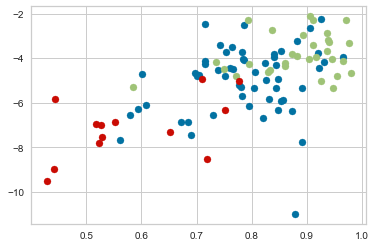

In [1339]:
# create scatter plot for samples from each cluster

for cluster in clusters:
   
    row_ix = np.where(labels == cluster)       # get row indexes for samples with this cluster
   
    pyplot.scatter(select_features.to_numpy()[row_ix, 1], select_features.to_numpy()[row_ix, 2])      # create scatter of these samples
                                                                        
pyplot.show()      # show the plot

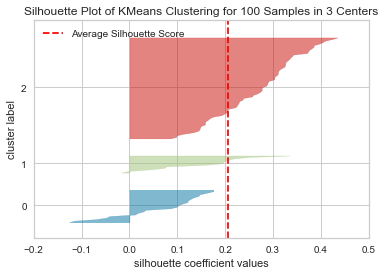

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 100 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [1340]:
# to check if the K value is correct and the songs are equally splitted in the groups (each color is the group).

from yellowbrick.cluster import SilhouetteVisualizer

model = KMeans(3, random_state=42)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X_scaled_df)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure


In [1341]:
# check how many observations has each cluster.

clusters = kmeans.predict(X_scaled_df)

#clusters

pd.Series(clusters).value_counts().sort_index()

0    56
1    31
2    13
dtype: int64

In [1342]:
# create a column of "cluster"

select_features["cluster"] = clusters
select_features

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,cluster
0,0.812,0.879,-10.998,0.0397,0.0167,0.224000,0.3660,0.962,129.991,0
1,0.740,0.820,-6.695,0.1300,0.0183,0.000005,0.3130,0.354,126.042,0
2,0.802,0.966,-3.933,0.0424,0.1800,0.000000,0.0611,0.684,130.099,0
3,0.757,0.892,-5.321,0.1240,0.1780,0.000042,0.0719,0.936,127.014,0
4,0.627,0.954,-4.804,0.0425,0.0015,0.000814,0.2920,0.312,128.016,1
...,...,...,...,...,...,...,...,...,...,...
95,0.912,0.716,-4.141,0.0697,0.0904,0.000000,0.0491,0.377,94.981,0
96,0.680,0.840,-3.823,0.0414,0.0457,0.000009,0.1430,0.468,104.975,0
97,0.660,0.805,-5.352,0.1530,0.0192,0.000009,0.1590,0.625,103.008,0
98,0.699,0.529,-7.548,0.0487,0.0317,0.000036,0.2850,0.121,119.987,2


###  Save the data frame of audiofeatures

In [1343]:
# save as csv

select_features.to_csv('song_features.csv', index = False) 

In [1344]:
# save as pickle

import pickle

with open("select_features.pickle", "wb") as f:
    pickle.dump(select_features,f)


In [1345]:
select_features[select_features['cluster'] == 0].sample()

# extract one song from cluster 2

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,cluster
40,0.675,0.602,-4.733,0.116,0.00377,0.0,0.0458,0.933,127.938,0


In [1346]:
select_features[select_features['cluster'] == 1].sample()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,cluster
42,0.684,0.834,-4.524,0.0675,0.0646,0.0,0.271,0.538,164.02,1


In [1347]:
select_features[select_features['cluster'] == 2].sample()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,cluster
66,0.887,0.441,-8.98,0.114,0.0514,0.00667,0.0338,0.715,129.908,2


### Check the mean audio features for each cluster

In [1348]:
select_features[select_features['cluster'] == 0].mean()

danceability          0.740464
energy                0.786768
loudness             -5.010875
speechiness           0.061139
acousticness          0.041901
instrumentalness      0.022994
liveness              0.132609
valence               0.667804
tempo               122.915714
cluster               0.000000
dtype: float64

In [1349]:
select_features[select_features['cluster'] == 1].mean()

danceability          0.623129
energy                0.879613
loudness             -3.834323
speechiness           0.168858
acousticness          0.080455
instrumentalness      0.000216
liveness              0.306552
valence               0.589774
tempo               132.159161
cluster               1.000000
dtype: float64

In [1350]:
select_features[select_features['cluster'] == 2].mean()

danceability         0.669154
energy               0.582154
loudness            -7.126538
speechiness          0.144438
acousticness         0.120120
instrumentalness     0.000553
liveness             0.156254
valence              0.392915
tempo               91.705231
cluster              2.000000
dtype: float64

In [1351]:
select_features


,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,cluster
0,0.812,0.879,-10.998,0.0397,0.0167,0.224000,0.3660,0.962,129.991,0
1,0.740,0.820,-6.695,0.1300,0.0183,0.000005,0.3130,0.354,126.042,0
2,0.802,0.966,-3.933,0.0424,0.1800,0.000000,0.0611,0.684,130.099,0
3,0.757,0.892,-5.321,0.1240,0.1780,0.000042,0.0719,0.936,127.014,0
4,0.627,0.954,-4.804,0.0425,0.0015,0.000814,0.2920,0.312,128.016,1
...,...,...,...,...,...,...,...,...,...,...
95,0.912,0.716,-4.141,0.0697,0.0904,0.000000,0.0491,0.377,94.981,0
96,0.680,0.840,-3.823,0.0414,0.0457,0.000009,0.1430,0.468,104.975,0
97,0.660,0.805,-5.352,0.1530,0.0192,0.000009,0.1590,0.625,103.008,0
98,0.699,0.529,-7.548,0.0487,0.0317,0.000036,0.2850,0.121,119.987,2


In [1352]:
Songs_df

,Singer,list_of_songs,list_of_id
0,Aqua,Barbie Girl,5ZrDlcxIDZyjOzHdYW1ydr
1,Revelries,Ayo Technology,3rdxkiSVNtrYwleW3TJMFs
2,O-Zone,Dragostea din tei,52Zr0sinhWTCRrQhRRY4EP
3,Teriyaki Boyz,"Tokyo Drift (Fast & Furious) - From ""The Fast ...",0upFohXrGxIIAjyaJmCkMU
4,Alex Gaudino,Destination Calabria - Radio Edit,5TmFTHZp7HjBXjjsFvCY6h
...,...,...,...
95,Iggy Azalea,Fancy,3W3KtDwAIg3mAruSpnfG3Q
96,Ella Henderson,Ghost,4XPWKmy05Rcff6TLHNoNF8
97,Ariana Grande,Problem,7vS3Y0IKjde7Xg85LWIEdP
98,Becky G,Shower,3DmW6y7wTEYHJZlLo1r6XJ


In [1353]:
song_features = pd.concat([Songs_df, select_features], axis=1)
song_features

,Singer,list_of_songs,list_of_id,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,cluster
0,Aqua,Barbie Girl,5ZrDlcxIDZyjOzHdYW1ydr,0.812,0.879,-10.998,0.0397,0.0167,0.224000,0.3660,0.962,129.991,0
1,Revelries,Ayo Technology,3rdxkiSVNtrYwleW3TJMFs,0.740,0.820,-6.695,0.1300,0.0183,0.000005,0.3130,0.354,126.042,0
2,O-Zone,Dragostea din tei,52Zr0sinhWTCRrQhRRY4EP,0.802,0.966,-3.933,0.0424,0.1800,0.000000,0.0611,0.684,130.099,0
3,Teriyaki Boyz,"Tokyo Drift (Fast & Furious) - From ""The Fast ...",0upFohXrGxIIAjyaJmCkMU,0.757,0.892,-5.321,0.1240,0.1780,0.000042,0.0719,0.936,127.014,0
4,Alex Gaudino,Destination Calabria - Radio Edit,5TmFTHZp7HjBXjjsFvCY6h,0.627,0.954,-4.804,0.0425,0.0015,0.000814,0.2920,0.312,128.016,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Iggy Azalea,Fancy,3W3KtDwAIg3mAruSpnfG3Q,0.912,0.716,-4.141,0.0697,0.0904,0.000000,0.0491,0.377,94.981,0
96,Ella Henderson,Ghost,4XPWKmy05Rcff6TLHNoNF8,0.680,0.840,-3.823,0.0414,0.0457,0.000009,0.1430,0.468,104.975,0
97,Ariana Grande,Problem,7vS3Y0IKjde7Xg85LWIEdP,0.660,0.805,-5.352,0.1530,0.0192,0.000009,0.1590,0.625,103.008,0
98,Becky G,Shower,3DmW6y7wTEYHJZlLo1r6XJ,0.699,0.529,-7.548,0.0487,0.0317,0.000036,0.2850,0.121,119.987,2


In [1354]:
# save the data frame with pickle

with open("song_features.pickle", "wb") as f:
    pickle.dump(song_features,f)